# Import Dataset from Yahoo Finance

In [141]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

# Define the company ticker symbol for Microsoft
company = "MSFT"

# Set the start date to 7 years before the current date
start_date = datetime.now() - timedelta(days=7*365)

# Set the end date to the current date
end_date = datetime.now()

# Download historical data from Yahoo Finance for the specified ticker and time period
# The progress bar is disabled with progress=False
data = yf.download(company, start=start_date, end=end_date, progress=False)

# Display the first few rows of the dataset 
print(data.head())

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2017-03-10  65.110001  65.260002  64.750000  64.930000  59.533710  19538200
2017-03-13  65.010002  65.190002  64.570000  64.709999  59.331997  20100000
2017-03-14  64.529999  64.550003  64.150002  64.410004  59.056938  14280200
2017-03-15  64.550003  64.919998  64.250000  64.750000  59.368675  24833800
2017-03-16  64.750000  64.760002  64.300003  64.639999  59.267818  20674300


## Data Dimension and Description 

In [149]:
# Data size 
data.shape

(1760, 6)

In [131]:
# Data description 
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1.760000e+03
mean,202.269068,204.292852,200.172079,202.336051,197.299023,2.874229e+07
std,94.814576,95.721709,93.884307,94.856377,95.883138,1.228937e+07
min,64.120003,64.550003,64.120003,64.209999,58.873554,7.425600e+06
25%,108.925001,109.750000,107.817501,108.719999,102.637856,2.105282e+07
50%,210.060005,212.300003,208.044998,210.195000,203.729034,2.573990e+07
75%,280.794998,283.994995,277.445007,280.742493,275.821770,3.282178e+07
max,420.559998,420.820007,415.089996,420.549988,419.773712,1.112421e+08


## Visualizing Microsoft Stock Closing Prices Over 7 Years with Yearly Color-Coded Trends

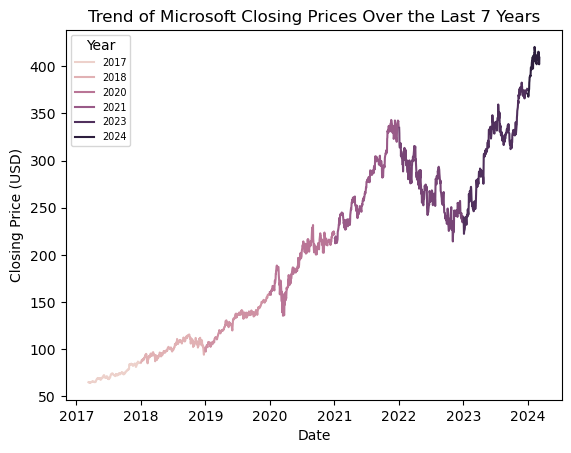

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the color palette to "husl" which is a color space that allows for better color differentiation
sns.set_palette("husl")

# Create a line plot of the closing prices for Microsoft stock over the last 7 years
# The color hue is set by the year of the data index, providing a color-coded trend over the years
sns.lineplot(data=data, x=data.index, y='Close', hue=data.index.year)

# Set the title of the plot and label the axes for clarity
plt.title('Trend of Microsoft Closing Prices Over the Last 7 Years')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')

# Place a legend on the upper left side of the plot, with a smaller font size for better readability
plt.legend(title='Year', loc='upper left', fontsize=7)

# Display the plot
plt.show()


## Dataset split into train and test set 

In [133]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Initialize the MinMaxScaler to scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

# Extract the 'Close' prices as a numpy array and reshape it to be 2-dimensional
prices = data['Close'].values.reshape(-1, 1)

# Fit the scaler to the closing prices and transform the data to the scaled version
prices_scaled = scaler.fit_transform(prices)

# Function to create sequences of data that will be used as the input to the LSTM model
def create_dataset(data, time_step=1):
    # X, Y are lists to hold the input/output data
    X, Y = [], []
    # Create sequences: a sequence of 'time_step' data points will be used to predict the next data point
    for i in range(len(data)-time_step-1):
        # Create the sequence of 'time_step' data points
        a = data[i:(i+time_step), 0]
        X.append(a)
        # Append the next data point that the sequence should predict
        Y.append(data[i + time_step, 0])
    # Return the sequences as numpy arrays
    return np.array(X), np.array(Y)

# Define the time_step for the sequences
time_step = 100

# Create the dataset with the specified time_step
X, y = create_dataset(prices_scaled, time_step)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input data to be in the form [samples, time steps, features], as required by LSTM network
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [47]:
X.shape, y.shape

((1659, 100), (1659,))

## LSTM Model

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Building a Sequential model for time series forecasting using LSTM
model = Sequential([
    # First LSTM layer with 'return_sequences=True' to pass the sequence to the next LSTM layer
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    # Dropout for regularization to prevent overfitting
    Dropout(0.5),
    # Second LSTM layer with 'return_sequences=False' to output only the last step of the sequence
    LSTM(50, return_sequences=False),
    # Dropout for regularization
    Dropout(0.5),
    # Dense layer with 15 neurons and ReLU activation function
    Dense(15, activation='relu'),
    # Output Dense layer with 1 neuron and linear activation function to predict the scaled closing price
    Dense(1, activation='linear')
])

# Output the summary of the model architecture
model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 100, 50)           10400     
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_21 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_21 (Dense)            (None, 15)                765       
                                                                 
 dense_22 (Dense)            (None, 1)                 16        
                                                                 
Total params: 31381 (122.58 KB)
Trainable params: 313

Epoch 1/30
17/17 [==============================] - 4s 85ms/step - loss: 0.0040 - val_loss: 7.0757e-04
Epoch 2/30
17/17 [==============================] - 1s 49ms/step - loss: 0.0027 - val_loss: 8.9475e-04
Epoch 3/30
17/17 [==============================] - 1s 49ms/step - loss: 0.0032 - val_loss: 5.4837e-04
Epoch 4/30
17/17 [==============================] - 1s 50ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 5/30
17/17 [==============================] - 1s 50ms/step - loss: 0.0026 - val_loss: 6.4941e-04
Epoch 6/30
17/17 [==============================] - 1s 50ms/step - loss: 0.0029 - val_loss: 9.0511e-04
Epoch 7/30
17/17 [==============================] - 1s 50ms/step - loss: 0.0024 - val_loss: 5.5278e-04
Epoch 8/30
17/17 [==============================] - 1s 50ms/step - loss: 0.0025 - val_loss: 8.6359e-04
Epoch 9/30
17/17 [==============================] - 1s 49ms/step - loss: 0.0023 - val_loss: 6.4715e-04
Epoch 10/30
17/17 [==============================] - 1s 49ms/step - loss: 0.0

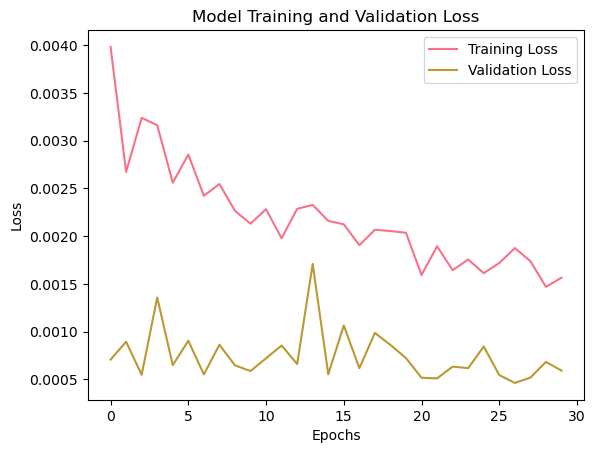

In [136]:
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Compile the LSTM model with the Adam optimizer and mean squared error loss function
# The learning rate is set to 0.001, which is a common starting point and may be adjusted based on performance.
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model on the training data for 30 epochs with a batch size of 64
# A validation split of 20% is used to monitor performance on unseen data during training
# 'verbose=1' outputs the training progress to the console
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.20, verbose=1)

# Plot the training and validation loss from the history object to visualize the learning process
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [145]:

# Use the trained model to make predictions on the training set
train_predict = model.predict(X_train).flatten() # Flatten the predictions to convert them from 2D to 1D array for easier handling

# Similarly, make predictions on the test set
test_predict = model.predict(X_test)

# Create a DataFrame to compare the actual closing prices and the model's predictions for the training set
# This is useful for visual evaluation of the model's performance on the training data
train_results = pd.DataFrame(data={'Train Predictions':scaler.inverse_transform(train_predict.reshape(-1,1)).flatten(),'Actuals':scaler.inverse_transform(y_train.reshape(-1,1)).flatten()})

# Display the DataFrame to see the comparison
train_results.head()  # Displaying only the first few entries for brevity



11/11 [==============================] - 0s 13ms/step


,Train Predictions,Actuals
0,111.494080,107.059998
1,98.038666,93.320000
2,139.421906,143.369995
3,213.461029,203.919998
4,238.874283,228.169998


## MSE calculation

In [146]:
# Calculate RMSE to evaluate performance
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.023433092535562958

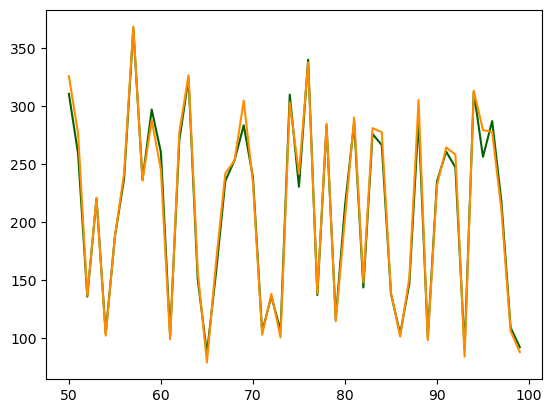

In [150]:
# Predictions and Actuals values plot 
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100],color='darkgreen')
plt.plot(train_results['Actuals'][50:100],color='darkorange')
plt.show()

## ARIMA Model

In [148]:

from statsmodels.tsa.arima.model import ARIMA

# Initialize and fit the ARIMA model with the historical closing prices
# The ARIMA model is specified to use 5 past values (p=5), to differenciate the data once (d=1), and to use a moving average window of size 0 (q=0)
Arima_model = ARIMA(prices, order=(5,1,0))
Arima_model_fit = Arima_model.fit()

# Make future predictions
# 'forecast' function is used to predict the next 5 days of prices
numb_step = 5
forecast = Arima_model_fit.forecast(steps=numb_step)

# Print the forecast values
# 'zip' is used to pair each forecasted value with its corresponding day
# The forecasted values are rounded to 2 decimal places for readability
forecast_dict = dict(zip(['day '+ str(i) for i in range(1, numb_step+1)], np.round(forecast, 2)))
print(forecast_dict)


{'day 1': 408.8, 'day 2': 408.42, 'day 3': 407.76, 'day 4': 407.9, 'day 5': 408.22}
